In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
import pickle
import math
from scipy import interpolate
import pycwt as wavelet
from pycwt.helpers import find
from typing import Union


# Simulation Model Definition

In [99]:
class AFM_Simulator():
    def __init__(self, model: str, tip_r: Union[int, float] =2, tap_dist=2000/1024):
        self.model = model
        self.tip_r = tip_r
        self.tap_dist = tap_dist
        '''
        Define the vertex coordinates of the cross-sectional model in fractional coordinates.
        For the lattice parameters of cellulose Iβ, refer to the following paper.
        Nishiyama, Y., Langan, P., & Chanzy, H. (2002). Crystal structure and hydrogen-bonding system in cellulose Iβ from synchrotron X-ray and neutron fiber diffraction. Journal of the American Chemical Society, 124(31), 9074-9082.
        '''
        self.formation_dict = {
            '18chain_rosen': self.lattice2orthogonal(np.array([-0.25, 0.25, 1.5, 1.5, -0.25, -0.75, -2, -2]),
                                                         np.array([-0.25, -0.25, 1, 2, 3.75, 3.75, 2.5, 1.5])),
            '18chain_daicho': self.lattice2orthogonal(np.array([-0.25, 1.25, 2.5, 0.75, -0.75, -2]),
                                                      np.array([-0.25, -0.25, 1, 2.75, 2.75, 1.5])),
            '18chain_daicho_laminated': self.lattice2orthogonal(np.array([-0.25, 1.25, 2.5, 1.75, 0.25, -1]),
                                                                np.array([-0.25, -0.25, 1, 1.75, 1.75, 0.5]))
            }

    @staticmethod
    def lattice2orthogonal(lattice_x, lattice_y):
        """
        Convert the coordinates based on the cellulose Iβ crystal lattice to orthogonal coordinates.
        """
        a = 0.7784
        b = 0.8201
        gamma = math.radians(96.5)

        gx = np.mean(lattice_x)
        gy = np.mean(lattice_y)
        x = np.round(a * (lattice_x - gx) + round(math.cos(gamma), 4) * b * (lattice_y - gy), 4)
        y = np.round(round(math.sin(gamma), 4) * b * (lattice_y - gy), 4)
        return x, y

    @staticmethod
    def rotation(x, t, deg=True):
        """
        Rotate the coordinates.
        if deg is True, the angle is in degrees. Otherwise, it is in radians.
        """
        #ラジアンでも弧度法でも良い(default: 弧度法)
        if deg == True:
            t = np.deg2rad(t)
        a = np.array([[np.cos(t), -np.sin(t)],
                      [np.sin(t), np.cos(t)]])
        if a.ndim > 2 or a.shape[0] != 2:
            a = a.reshape(2, -1)
        ax = np.dot(a, x)
        return ax


    def _simulate_single_scan(self, angle, offset):
        """
        Simulate the AFM scanning for the given rotation angle and initial tapping position.
        When a sphere with radius r collides with CNF,
        the trajectory of the center of the sphere is considered.
        When the sphere collides with CNF,
        1. If the sphere collides with an edge, move the edge of CNF parallel to the distance r.
        2. If the sphere collides with a vertex, consider a circle with radius r centered on the vertex of CNF.

        Parameters
        ----------
        angle:float or int
            Rotation angle of CNF
        offset: float or int
            Initial tapping position

        Returns
        -------
        single_scan: List
            CNF height at the tapping position
        """
        tapping_posi = np.arange(-8 + offset, 8, self.tap_dist)

        coordinate = np.vstack(self.formation_dict[self.model])
        coor_rotated = self.rotation(coordinate, angle)

        cnf_bottom = np.min(coor_rotated[1])
        #　Find the locus of the straight line drawn by the center of the circle when the circle collides with the edge of the CNF.
        edge_vector = np.roll(coor_rotated, shift=-1, axis=1) - coor_rotated
        moves = self.tip_r * self.rotation(edge_vector, -90) / np.linalg.norm(edge_vector, axis=0)  #平行移動の方向

        equations = []  #Equation of the straight line drawn by the center of the sphere
        x_ranges = []  #Domain of an equation
        for i, move in enumerate(moves.T):
            x1, x2 = coor_rotated[0][i] + move[0], np.roll(coor_rotated, shift=-1, axis=1)[0][i] + move[0]
            y1, y2 = coor_rotated[1][i] + move[1], np.roll(coor_rotated, shift=-1, axis=1)[1][i] + move[1]

            x_array = np.array([x1, x2])
            y_array = np.array([y1, y2])
            equation = np.poly1d(np.polyfit(x_array, y_array, 1))
            equations.append(equation)
            x_ranges.append((np.min(x_array), np.max(x_array)))

        #Scan once
        single_scan = []
        for x in tapping_posi:
            height_candidate = [0]  #If it doesn't hit the CNF, height is 0.

            #1. In case of a collision with the edge of CNF
            for equation, x_range in zip(equations, x_ranges):
                if x_range[0] <= x and x <= x_range[1]:
                    height_candidate.append(equation(x) - self.tip_r - cnf_bottom)
            #2. In the case of a collision at a vertex of CNF
            for vertex in coor_rotated.T:
                if abs(x - vertex[0]) <= self.tip_r:
                    cy = vertex[1] + math.sqrt(self.tip_r ** 2 - (x - vertex[0]) ** 2)
                    height_candidate.append(cy - self.tip_r - cnf_bottom)

            single_scan.append(max(height_candidate))
        return single_scan

    def calc_thin_height(self, angle, offset):
        """
        Measure the central height of CNF from the simulation results obtained by simulate_single_scan.

        Parameters
        ----------
        angle: float or int
            Rotation angle of CNF
        offset: float or int
            Initial tapping position

        Returns
        -------
        thin_height: float
            Central height of CNF
        """
        heights_array = np.array(self._simulate_single_scan(angle, offset))
        fiber_heights = heights_array[heights_array > 0]

        if len(fiber_heights) % 2 == 1:
            thin_index = len(fiber_heights) // 2
            thin_height = fiber_heights[thin_index]

        else:
            thin_index = int(len(fiber_heights) / 2)
            thin_height = (fiber_heights[thin_index] + fiber_heights[thin_index - 1]) / 2
        return thin_height

    def show_shape(self, angle):
        """
        Show the shape of CNF for the given rotation angle.

        Parameters
        ----------
        angle: float or int
            Rotation angle of CNF

        Returns
        -------
        coor_rotated: ndarray
            Coordinates of the rotated CNF
        """
        coordinate = np.vstack(self.formation_dict[self.model])
        coordinate = np.hstack((coordinate, coordinate[:, 0:1]))
        coor_rotated = self.rotation(coordinate, angle)
        return coor_rotated
    
    def calc_mid_height_and_range(self, angles):
        """
        Calculate the central height and range of CNF for the given rotation angles.
        
        Parameters
        ----------
        angles: ndarray
            Rotation angles of CNF. Input 1D array or 2D array.
            
        Returns
        -------
        mid_heights: ndarray
            Central height of CNF for the given rotation angles
        height_ranges: ndarray
            Height range of CNF for the given rotation angles
        """
        max_heights, min_heights = self.calc_max_and_min_heights(angles)
        mid_heights = (max_heights + min_heights) / 2
        height_ranges = max_heights - min_heights
        return mid_heights, height_ranges

    def calc_max_and_min_heights(self, angles):
        """
        Calculate the maximum and minimum heights of CNF for the given rotation angles.
        
        Parameters
        ----------
        angles: ndarray
            Rotation angles of CNF. Input 1D array or 2D array.
            
        Returns
        -------
        max_heights: nearray
            Maximum height of CNF for the given rotation angles
        min_heights: ndarray
            Minimum height of CNF for the given rotation angles
        """
        offsets = np.linspace(0, self.tap_dist, 100)
        if angles.ndim == 1:
            max_heights = []
            min_heights = []
            for angle in angles:
                height_list = []
                for offset in offsets:
                    thin_height = self.calc_thin_height(angle, offset)
                    height_list.append(thin_height)

                max_heights.append(max(height_list))
                min_heights.append(min(height_list))
            return np.array(max_heights), np.array(min_heights)

        if angles.ndim == 2:
            max_heights_mat = []
            min_heights_mat = []
            for angle_row in angles:
                max_heights = []
                min_heights = []
                for angle in angle_row:
                    height_list = []
                    for offset in offsets:
                        thin_height = self.calc_thin_height(angle, offset)
                        height_list.append(thin_height)
                    max_heights.append(max(height_list))
                    min_heights.append(min(height_list))
                max_heights_mat.append(max_heights)
                min_heights_mat.append(min_heights)
            return np.array(max_heights_mat), np.array(min_heights_mat)
        
    def random_offset_scans(self, angles):
        """
        Perform a simulation in which only one random initial tapping position occurs for each rotation angle.

        Parameters
        ----------
        angles: ndarray
            Rotation angles of CNF. Input 1D array.

        Returns
        -------
        random_offsets: ndarray
            Random initial tapping position for each rotation angle
        """
        random_offsets = np.random.uniform(0, self.tap_dist, len(angles))
        scans = []
        for angle, offset in zip(angles, random_offsets):
            scans.append(self.calc_thin_height(angle, offset))
        return np.array(scans)
        

# Calculation of theoretical height range of CNF

For model A shown in Figure S5

In [100]:
afm_sim = AFM_Simulator('18chain_daicho')
angles = np.arange(0, 180)
max_heights, min_heights = afm_sim.calc_max_and_min_heights(angles)
mid_heights, height_range = afm_sim.calc_mid_height_and_range(angles)
f_mid = interpolate.interp1d(angles, mid_heights, kind='linear')
f_range = interpolate.interp1d(angles, height_range, kind='linear')

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/41182

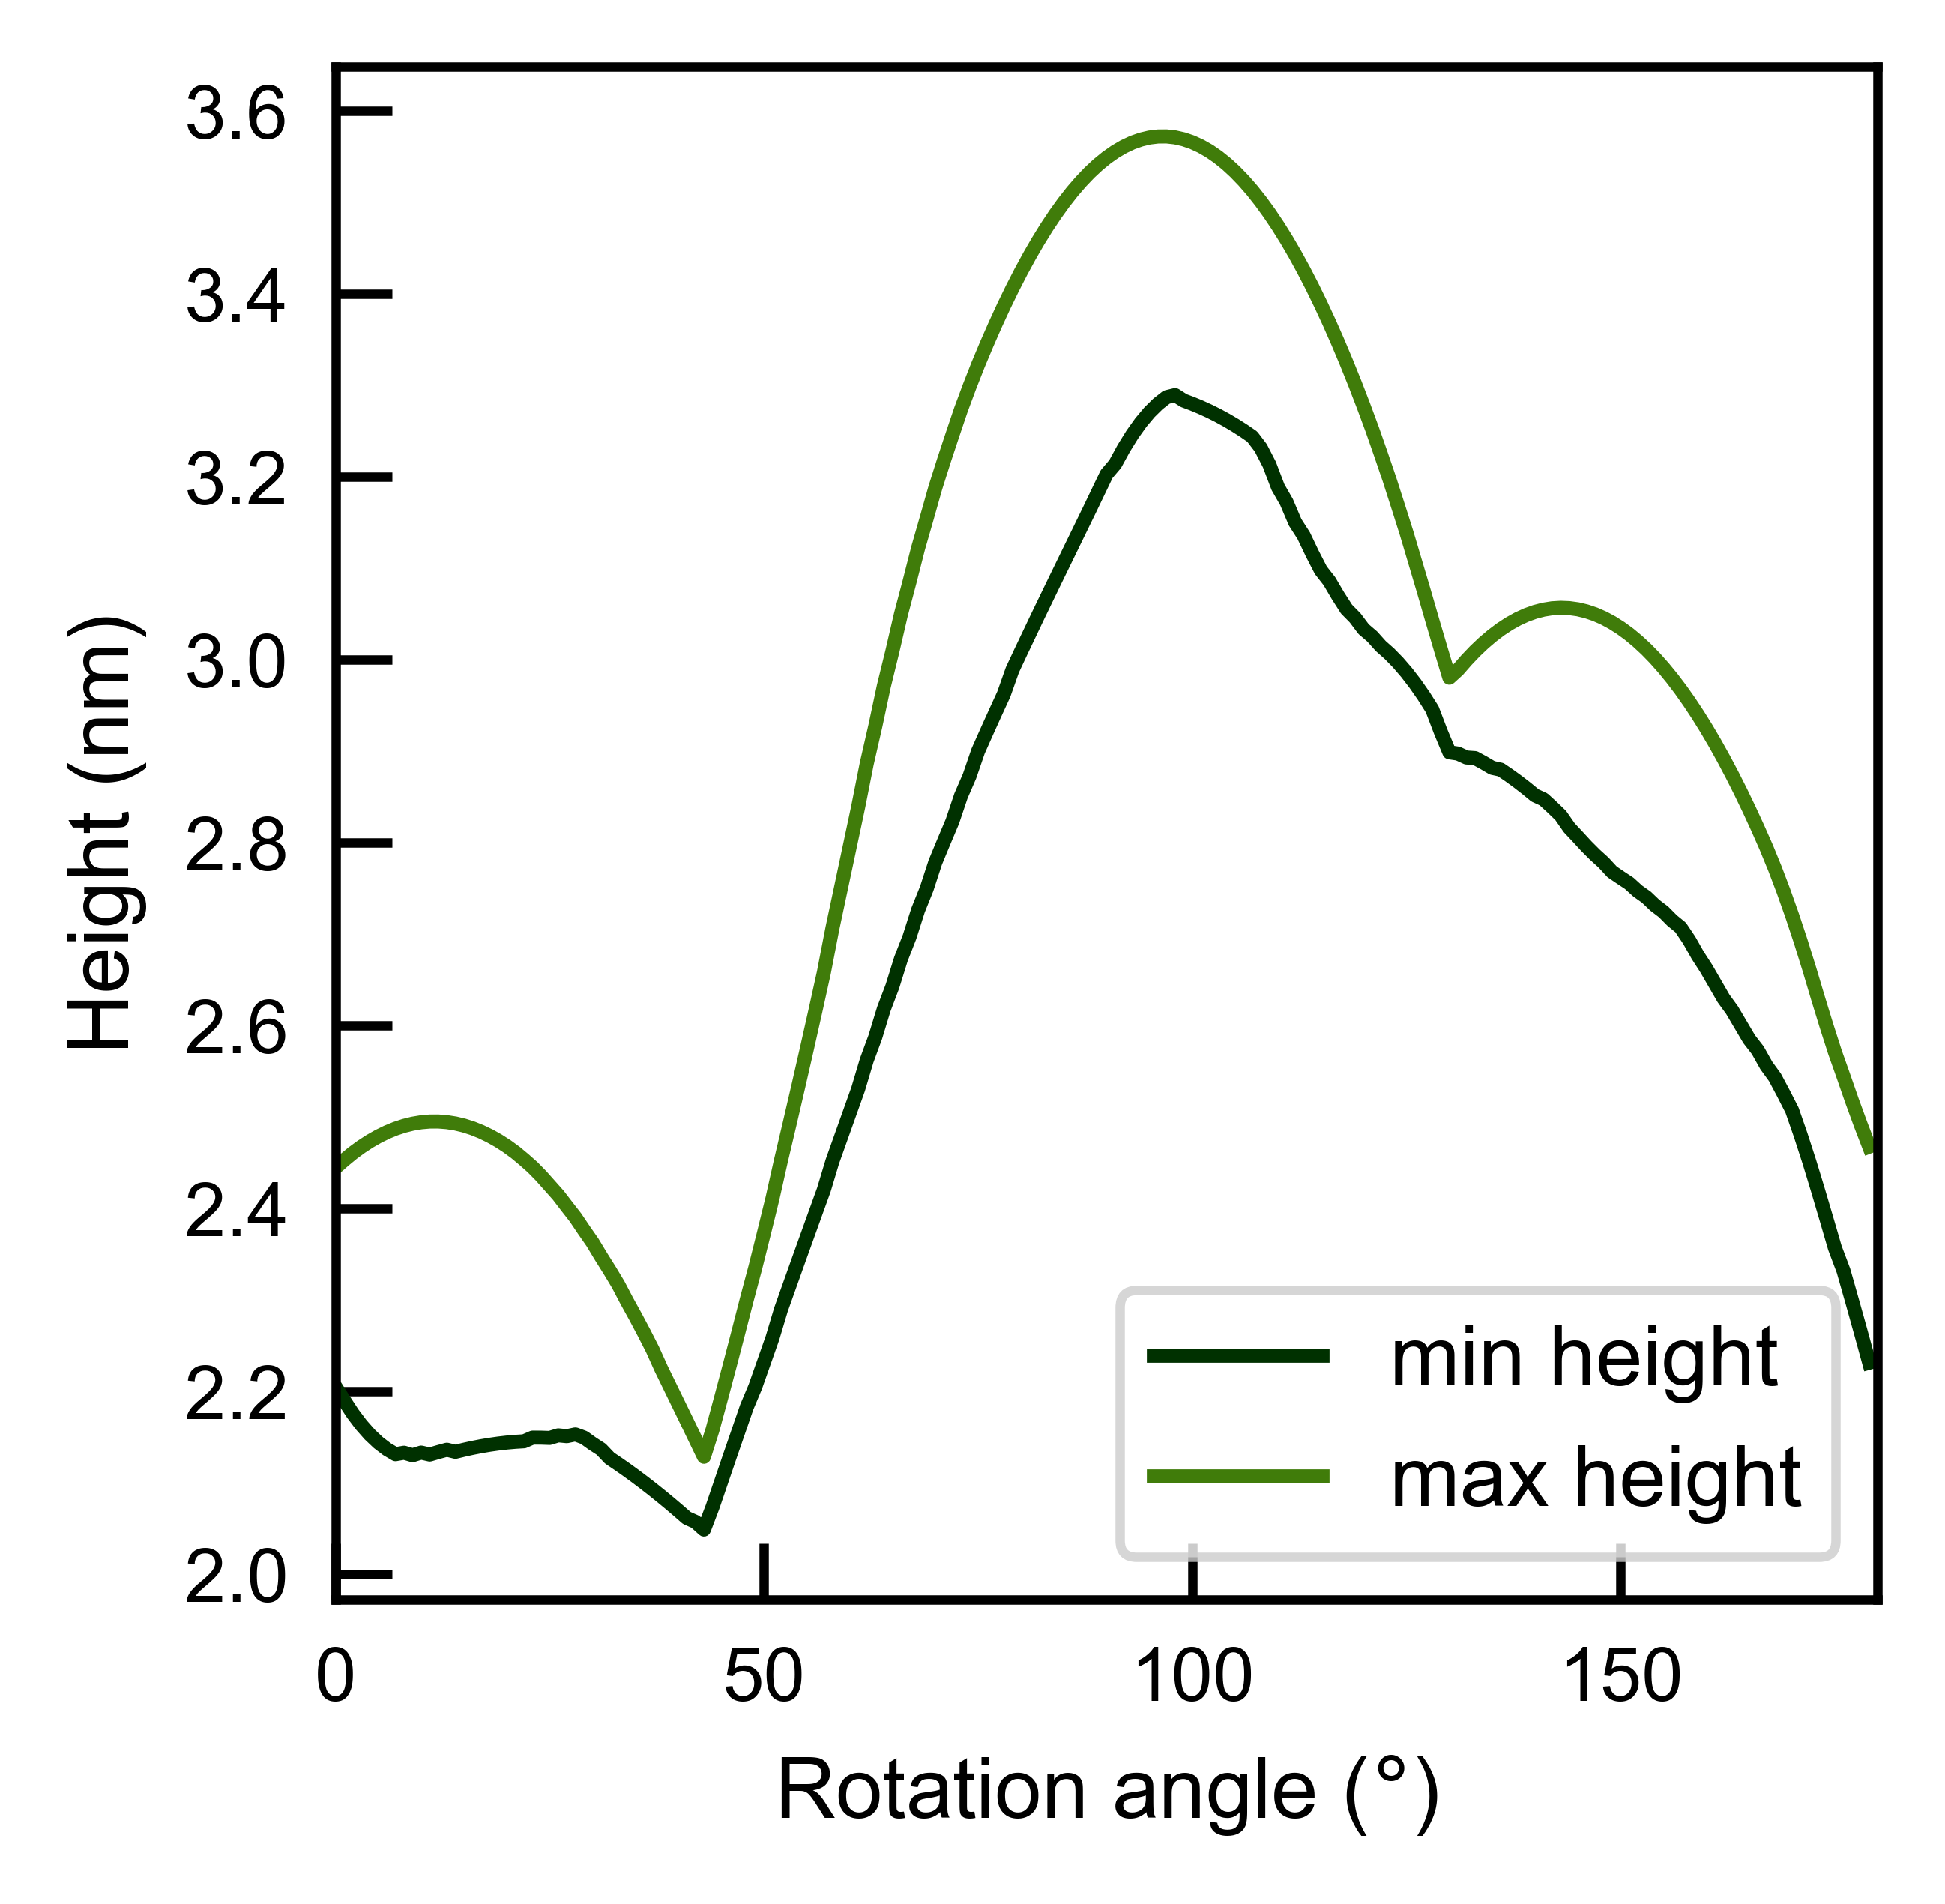

In [101]:
fig, ax = plt.subplots(1, 1)
ax.plot(angles, min_heights, label='min height')
ax.plot(angles, max_heights, label='max height')
ax.set_xlabel('Rotation angle ($\\degree$)')
ax.set_ylabel('Height (nm)')
ax.set_xlim(0, 180)
ax.legend()
plt.show()

In [102]:

print(min(min_heights))
print(max(max_heights))

2.048777680705778
3.5723900776758843


For model B

In [103]:
afm_sim = AFM_Simulator('18chain_rosen')
angles = np.arange(0, 180)
max_heights, min_heights = afm_sim.calc_max_and_min_heights(angles)
mid_heights, height_range = afm_sim.calc_mid_height_and_range(angles)
f_mid = interpolate.interp1d(angles, mid_heights, kind='linear')
f_range = interpolate.interp1d(angles, height_range, kind='linear')

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/41182

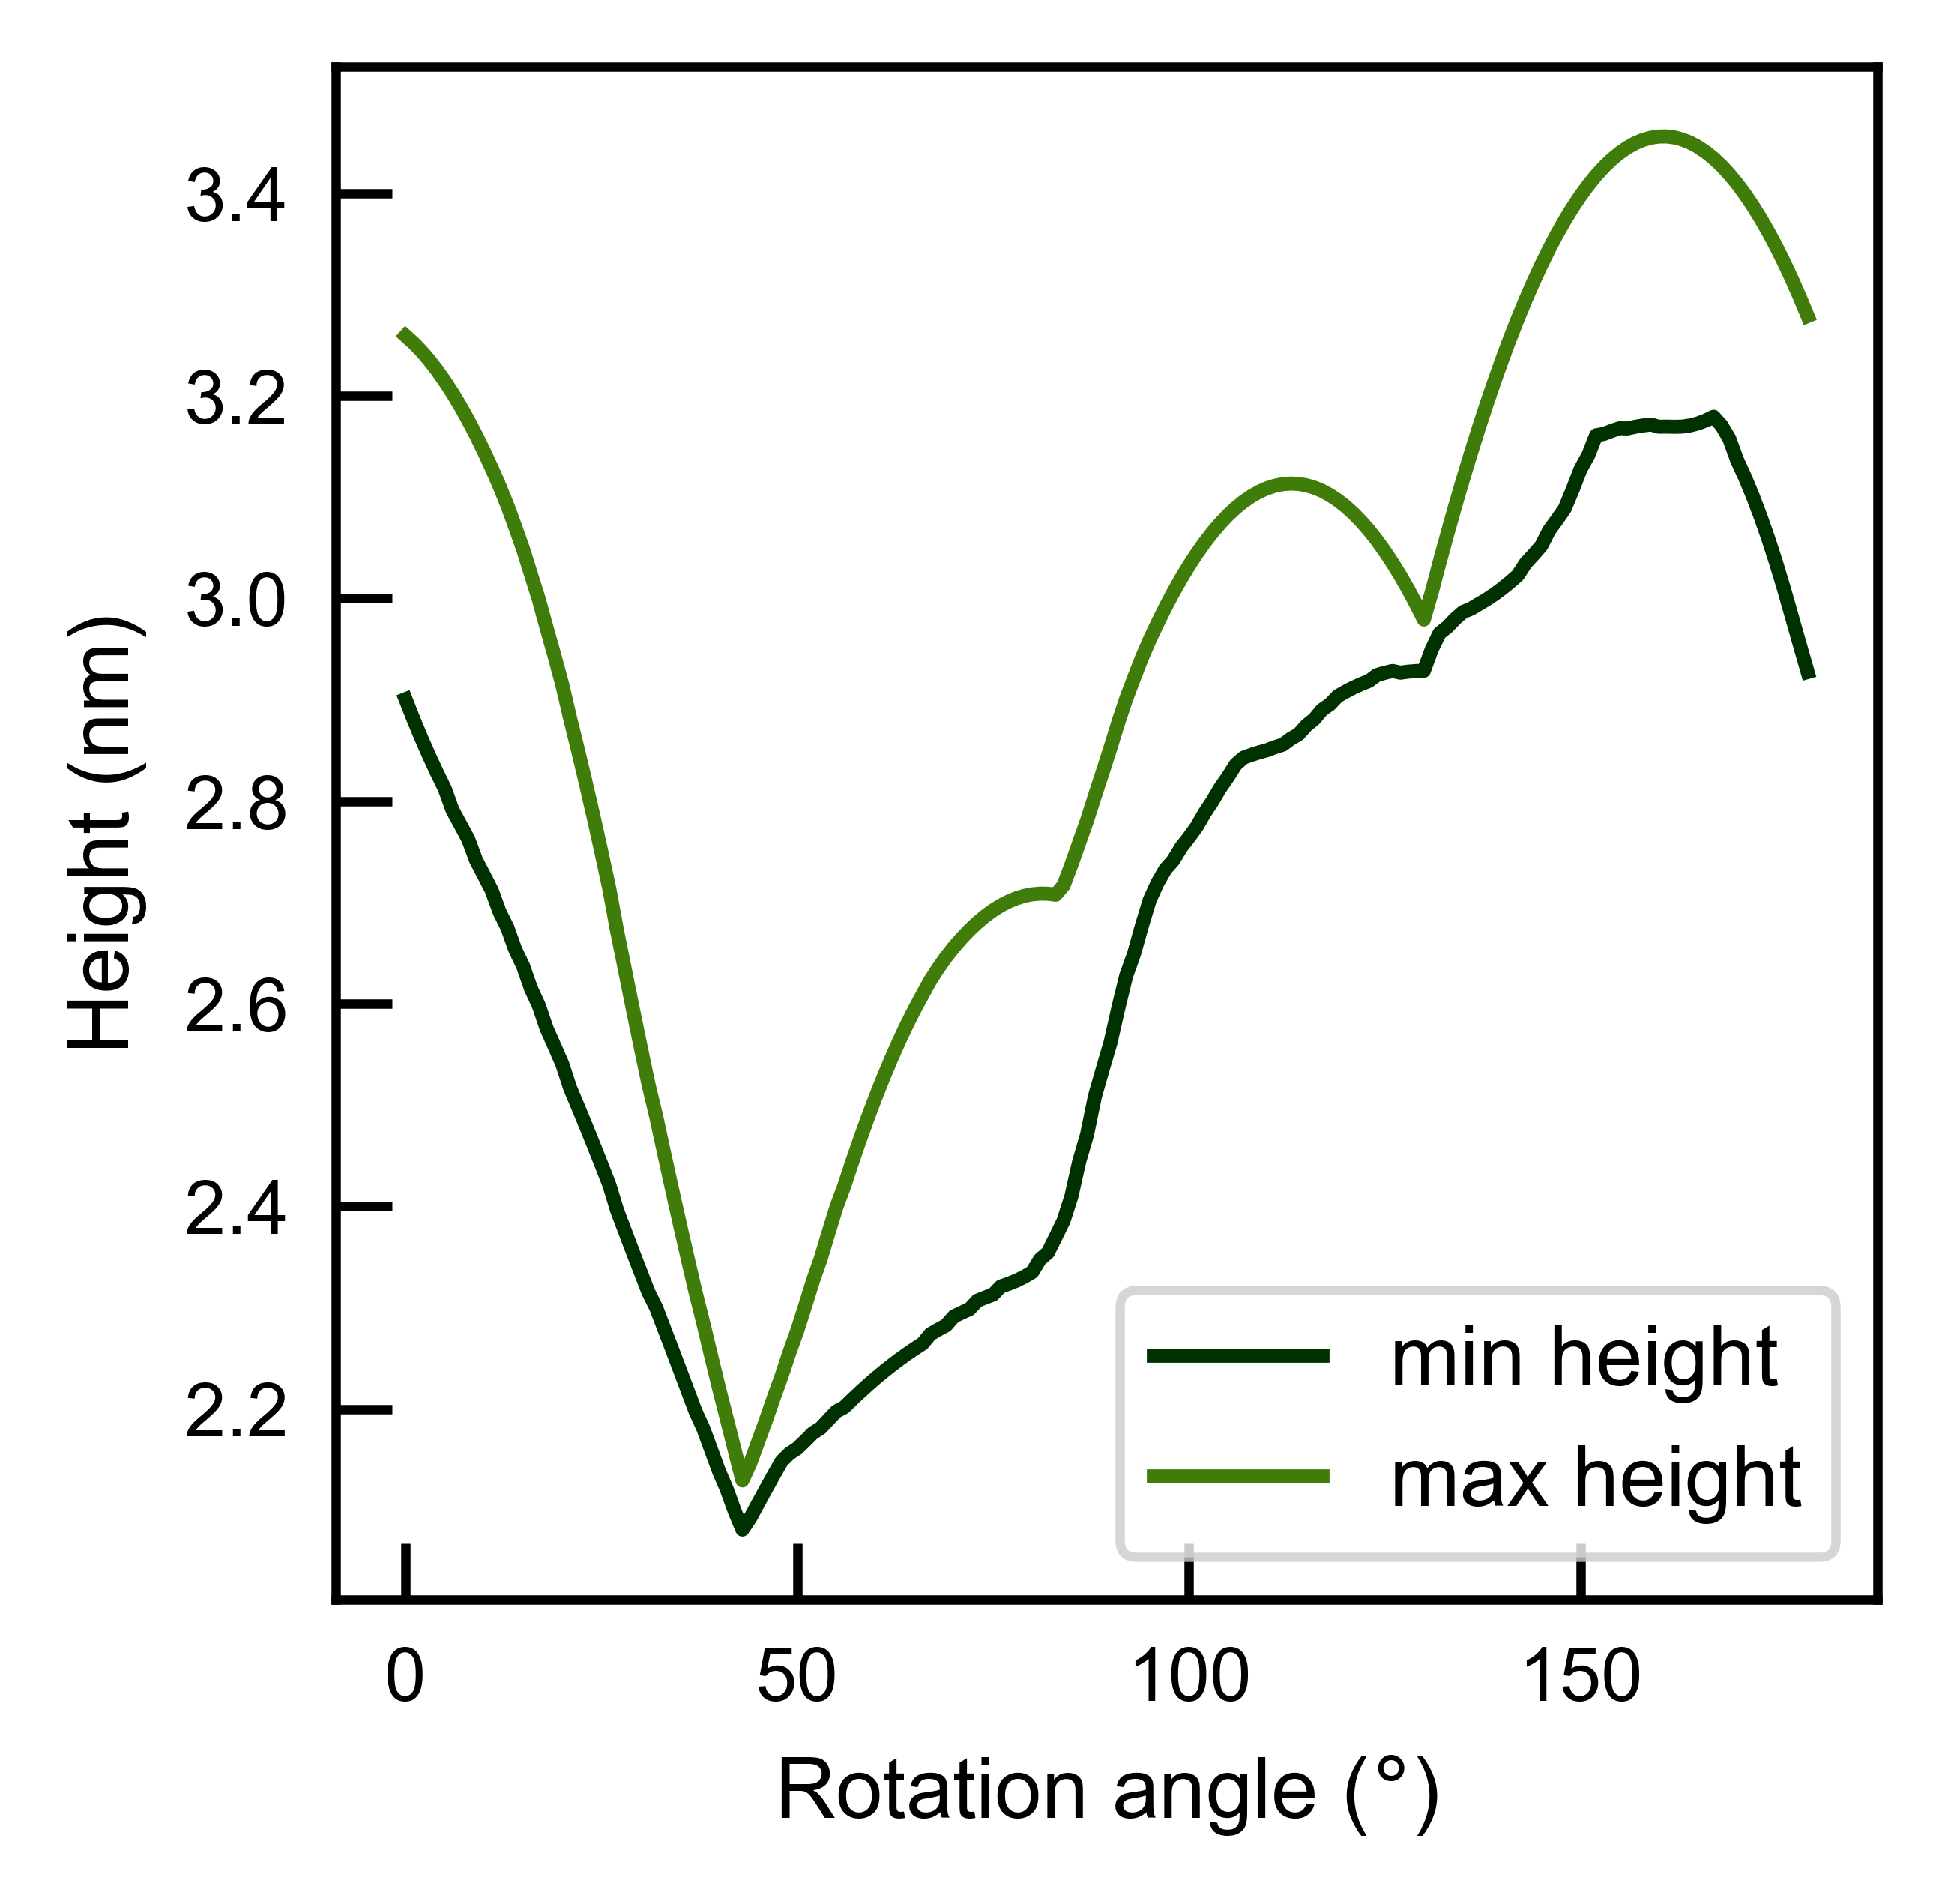

In [104]:
fig, ax = plt.subplots(1, 1)
ax.plot(angles, min_heights, label='min height')
ax.plot(angles, max_heights, label='max height')
ax.set_xlabel('Rotation angle ($\\degree$)')
ax.set_ylabel('Height (nm)')
ax.set_xlim(0, 180)
ax.legend()
plt.show()

In [105]:
print(min(min_heights))
print(max(max_heights))

2.0808156776960987
3.456159172949934


# Height profile for defect-free CNF

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/41182

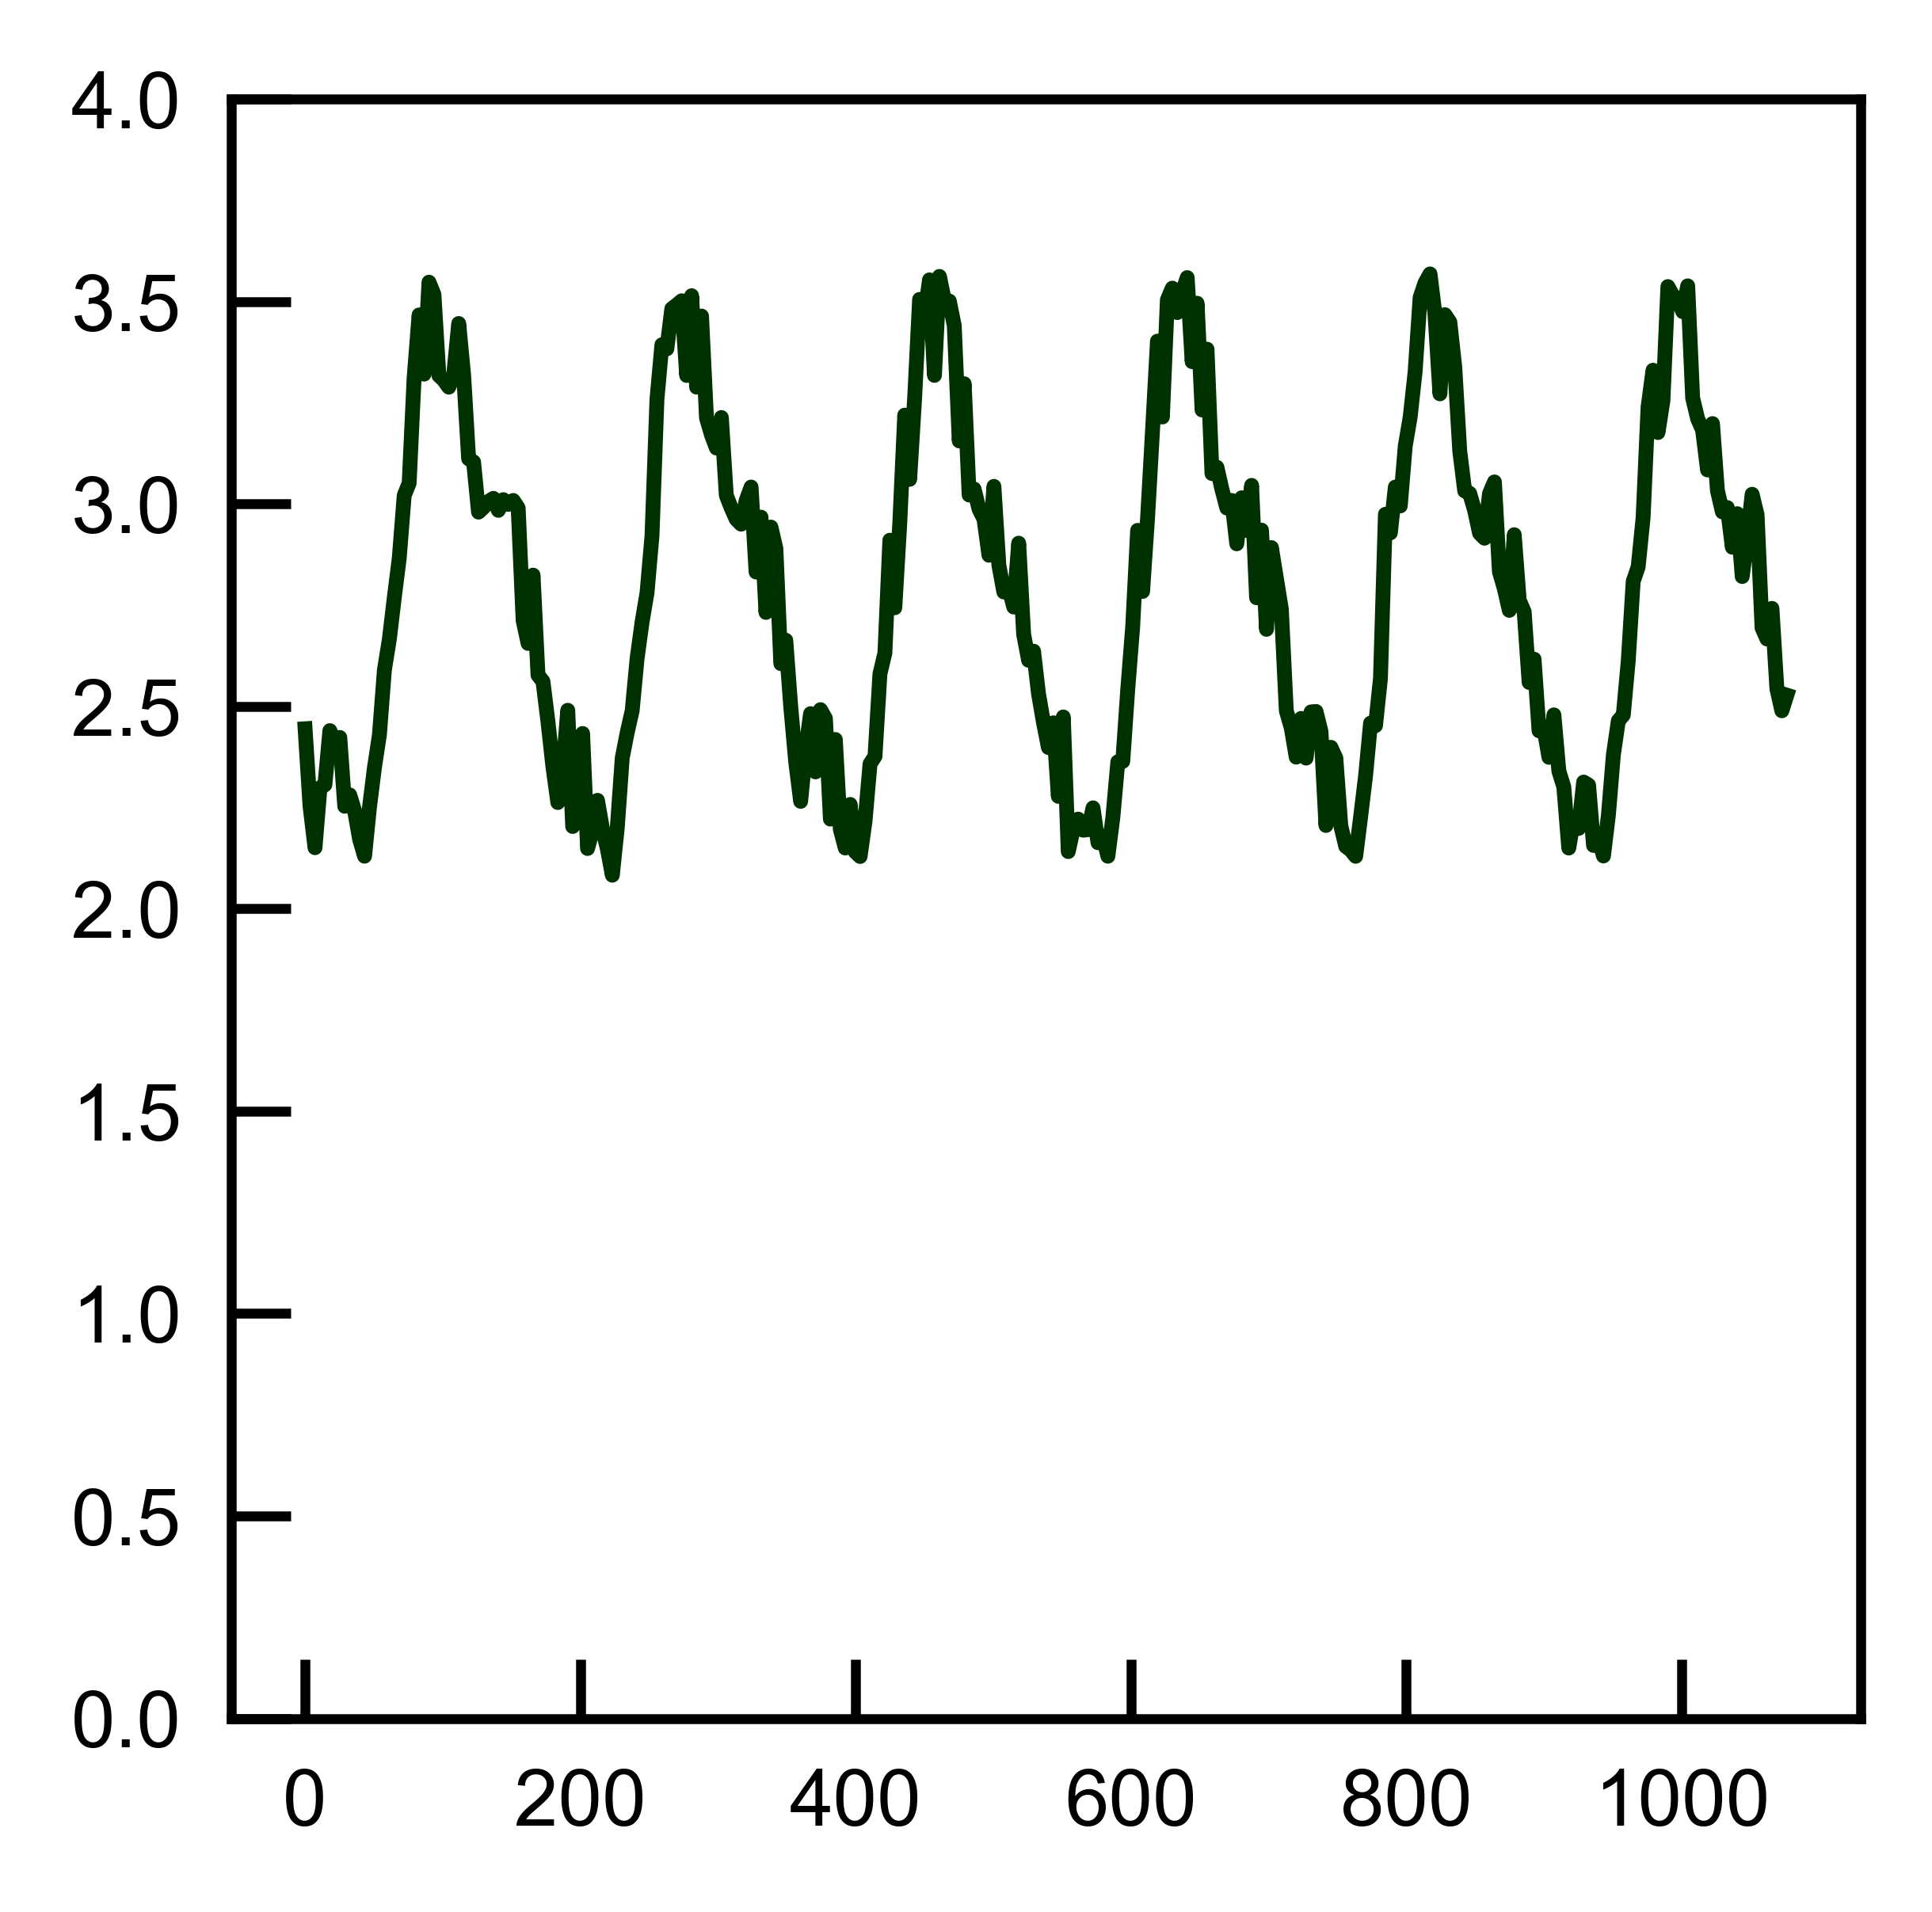

In [106]:
afm_sim = AFM_Simulator('18chain_daicho')
angles = np.arange(0, 1080, 3.6)
scans = afm_sim.random_offset_scans(angles)

fig, ax = plt.subplots(1, 1)
ax.plot(angles, scans)
ax.set_ylim(0, 4)

plt.show()

## Wavelet transform for defect-free CNF

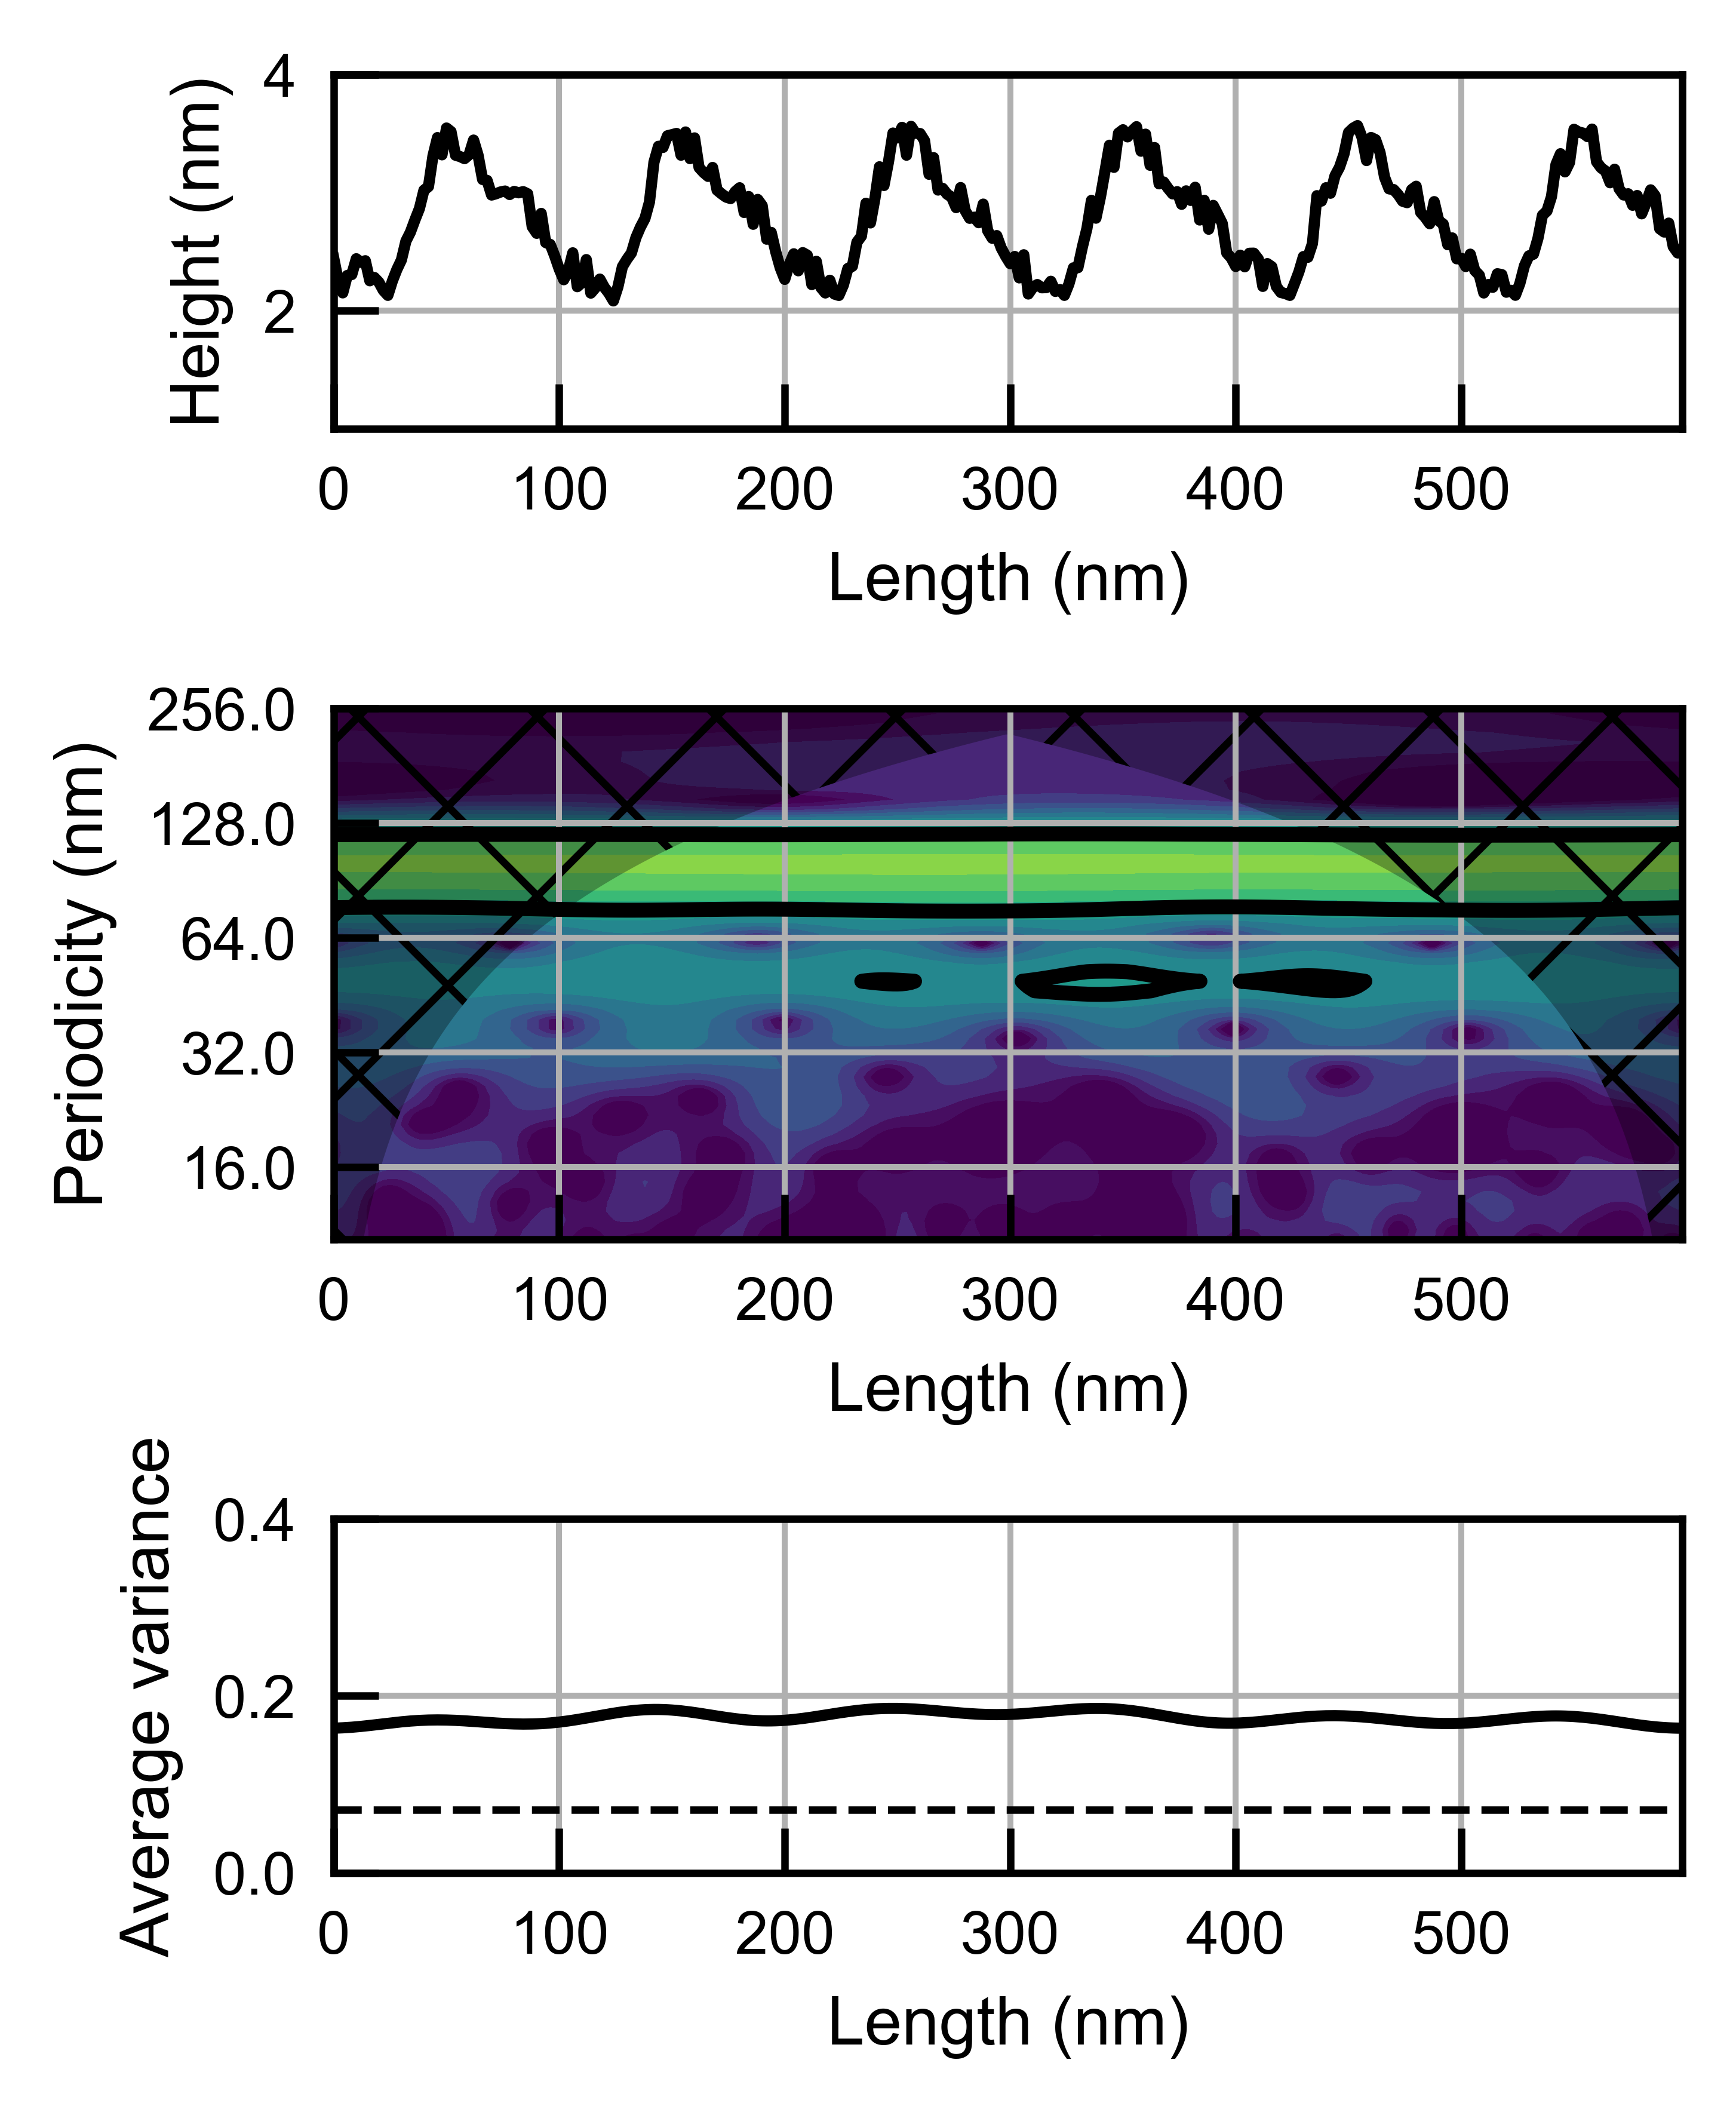

In [107]:
try:
    dt = 2
    height = scans
    horizon = np.arange(0, len(height) * dt, dt)

    slevel = 0.95                        # Significance level

    std = height.std()                      # Standard deviation
    std2 = std ** 2                      # Variance
    dat = (height - height.mean()) / std       # Calculating anomaly and normalizing
    dat = np.where((-3 < dat) & (dat < 3), dat, 0) # 極端な値を除去
    
    N = dat.size                            # Number of measurements

    dj = 1 / 12 # 1 /  12                     # Twelve sub-octaves per octaves
    s0 = 5 * dt  # 2 * dt                    # Starting scale, here 6 months
    J = 7 / dj  # 7 / dj                     # Seven powers of two with dj sub-octaves
    #  alpha = 0.0                       # Lag-1 autocorrelation for white noise
    try:
        alpha, _, _ = wavelet.ar1(dat)   # Lag-1 autocorrelation for red noise
    except Warning:
        # When the dataset is too short, or there is a strong trend, ar1 raises a
        # warning. In this case, we assume a white noise background spectrum.
        alpha = 1.0

    mother = wavelet.Morlet(6)           # Morlet mother wavelet with m=6

    # The following routines perform the wavelet transform and siginificance
    # analysis for the chosen data set.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother)

    # Normalized wavelet and Fourier power spectra
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    avg1, avg2 = (32, 128)                  # Range of periods to average

    # Significance test. Where ratio power/sig95 > 1, power is significant.
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=slevel,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    # Power rectification as of Liu et al. (2007). TODO: confirm if significance
    # test ratio should be calculated first.
    # power /= scales[:, None]

    # Calculates the global wavelet spectrum and determines its significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales                     # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                                            significance_level=slevel, dof=dof,
                                            wavelet=mother)

    # Scale average between avg1 and avg2 periods and significance level
    sel = find((period >= avg1) & (period < avg2))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((N, 1))).transpose()
    # As in Torrence and Compo (1998) equation 24
    scale_avg = power / scale_avg
    scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                                                 significance_level=slevel,
                                                 dof=[scales[sel[0]],
                                                      scales[sel[-1]]],
                                                 wavelet=mother)

    fig = plt.figure(figsize=(3.3, 4))
    # gs = GridSpec(3, 2, width_ratios=[3, 1], height_ratios=[2, 3, 2])
    gs = GridSpec(3, 1, height_ratios=[2, 3, 2])

    ax_nino3 = fig.add_subplot(gs[0, 0])
    ax_wave = fig.add_subplot(gs[1, 0], sharex=ax_nino3)
    # ax_gl_spec = fig.add_subplot(gs[1, 1], sharey=ax_wave)
    ax_scl_avg = fig.add_subplot(gs[2, 0], sharex=ax_nino3)
    # for a in [ax_nino3, ax_wave, ax_gl_spec, ax_scl_avg]:
    for a in [ax_nino3, ax_wave, ax_scl_avg]:
        a.grid(True)

    ax_nino3.plot(horizon, height, 'k', linewidth=1.5)
    ax_nino3.set_ylim(1,4)
    ax_nino3.set_ylabel('Height (nm)')
    ax_nino3.set_xlabel('Length (nm)')

    # Contour plot wavelet power spectrum
    # ax_wave.set_title('Wavelet Scalogram')
    # levels = np.exp2(np.arange(-5, 6))
    levels = np.exp2(np.arange(-5, 10))
    ax_wave.contourf(horizon, np.log2(period), np.log2(power), np.log2(levels),
                     extend='both', cmap=plt.cm.viridis)
    extent = horizon.min(), horizon.max(), 0, max(period)

    ax_wave.contour(horizon, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                    extent=extent) # 95% significance contour

    ax_wave.fill(np.concatenate([horizon, horizon[-1:] + dt, horizon[-1:] + dt,
                                 horizon[:1] - dt, horizon[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')

    ax_wave.set_ylabel('Periodicity (nm)')
    ax_wave.set_xlabel('Length (nm)')
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                            np.ceil(np.log2(period.max())))
    ax_wave.set_yticks(np.log2(Yticks))
    ax_wave.set_yticklabels(Yticks)
    ax_wave.set_ylim(np.log2([period.min(), 256]))


    # Scale-averaged power spectrum
    ax_scl_avg.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
    ax_scl_avg.plot(horizon, scale_avg, 'k-', linewidth=1.5)
    ax_scl_avg.set_xlabel('Length (nm)')
    ax_scl_avg.set_ylabel('Average variance')

    ax_scl_avg.set_xlim([horizon.min(), horizon.max()])
    ax_scl_avg.set_yticks(np.arange(0, 0.6, 0.2))

    plt.tight_layout()
    
    plt.show()
except RuntimeWarning:
    print('Divided by zero')

# Code for when the molecular sheet peels off with a 40% probability

## Height profile when the peeling probability is 100%

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/4118297391.py:91: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_69843/41182

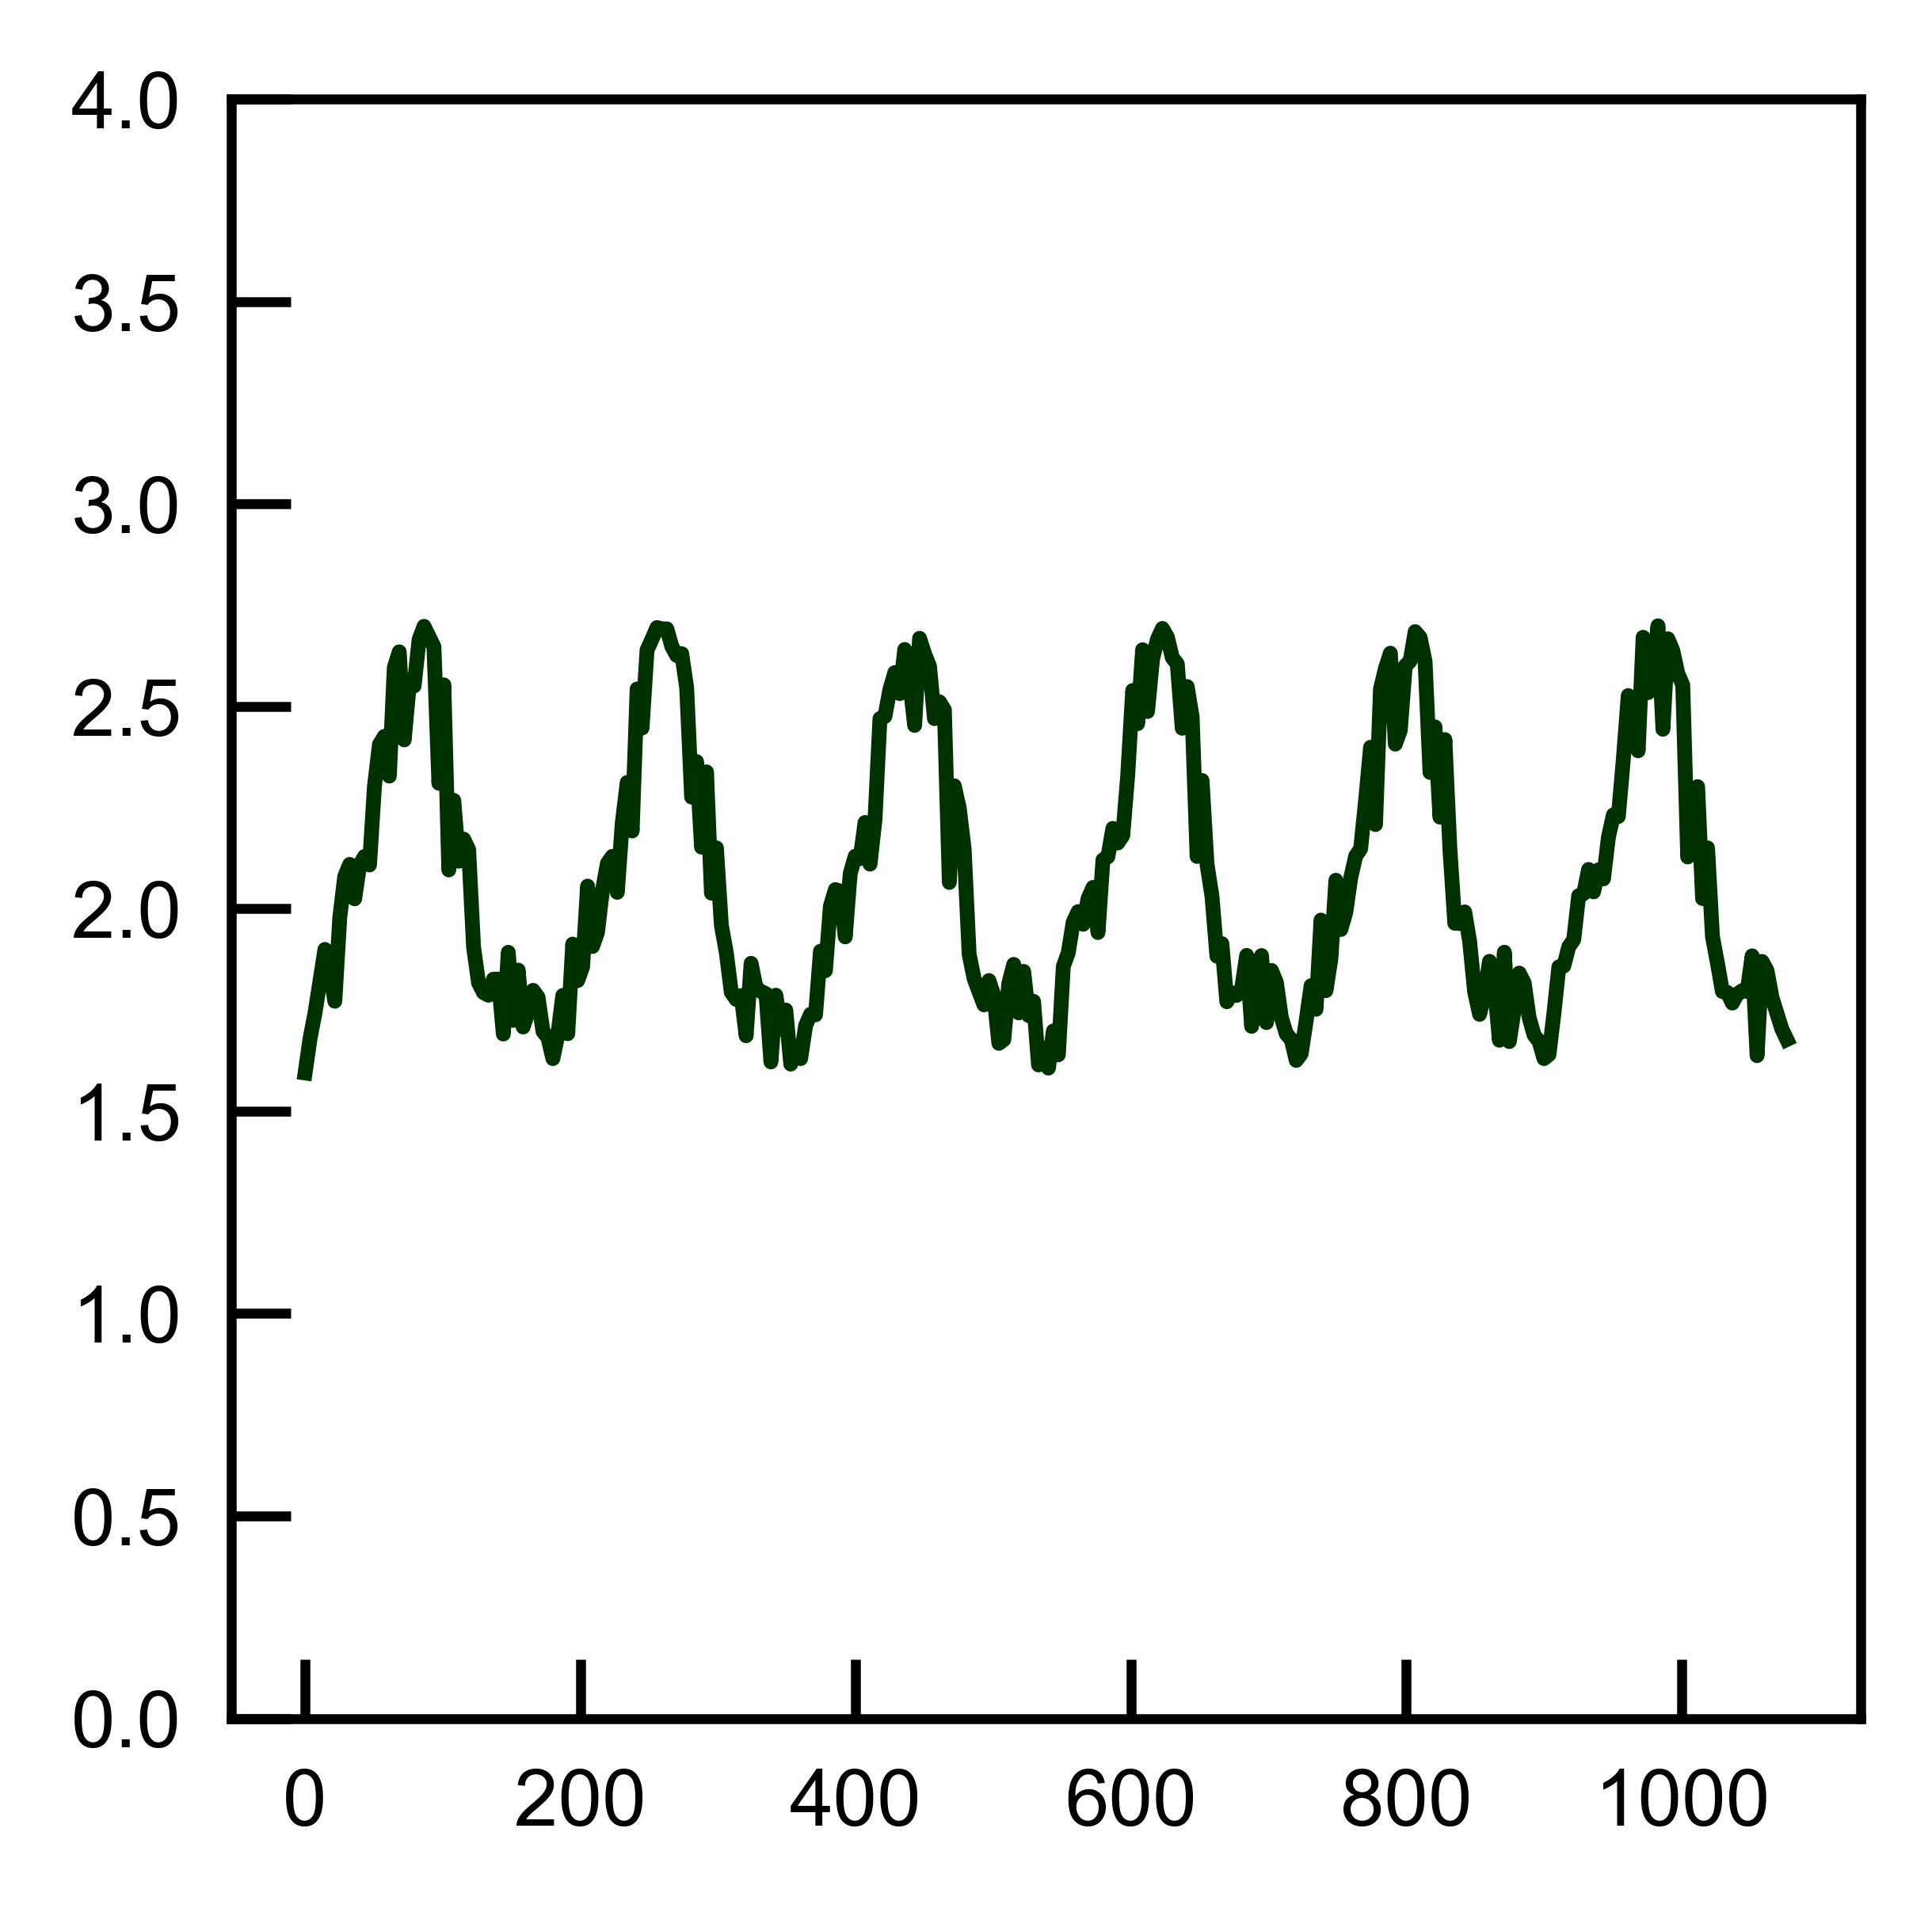

In [86]:
afm_sim = AFM_Simulator('18chain_daicho_laminated')
angles = np.arange(0, 1080, 3.6)
scans_laminated = afm_sim.random_offset_scans(angles)

fig, ax = plt.subplots(1, 1)
ax.plot(angles, scans_laminated)
ax.set_ylim(0, 4)
plt.show()

## Generate a sequence in which 0 (which indicates the position where the molecular chain is peeled off) appears at least five times in a row.

In [87]:
def generate_sequence(sequence_length, zero_ratio, min_zero_run_length):
    # 0の割合を計算
    zero_count = int(sequence_length * zero_ratio)
    one_count = sequence_length - zero_count

    # 0の連続部分の可能な最大数を計算
    max_zero_runs = zero_count // min_zero_run_length
    if max_zero_runs == 0:
        zero_runs = 1
    else:
        # 0の連続部分の数を1から最大数までのランダムな整数で決定
        zero_runs = np.random.randint(1, max_zero_runs + 1)

    # 各0の連続部分の初期長さを設定
    zero_run_lengths = [min_zero_run_length] * zero_runs
    remaining_zeros = zero_count - (min_zero_run_length * zero_runs)

    if remaining_zeros > 0:
        # 残りの0をランダムに分配
        extra_zeros = np.random.multinomial(remaining_zeros, [1/zero_runs]*zero_runs)
        zero_run_lengths = [length + extra for length, extra in zip(zero_run_lengths, extra_zeros)]

    # シーケンスの開始を0または1でランダムに決定
    start_with_zero = np.random.choice([True, False])

    if start_with_zero:
        one_runs = zero_runs - 1
    else:
        one_runs = zero_runs + 1

    # 各1の連続部分の初期長さを設定
    if one_runs > 0:
        min_one_run_length = 1
        one_run_lengths = [min_one_run_length] * one_runs
        remaining_ones = one_count - (min_one_run_length * one_runs)

        if remaining_ones > 0:
            # 残りの1をランダムに分配
            extra_ones = np.random.multinomial(remaining_ones, [1/one_runs]*one_runs)
            one_run_lengths = [length + extra for length, extra in zip(one_run_lengths, extra_ones)]
    else:
        one_run_lengths = []

    # シーケンスを構築
    sequence = []
    if start_with_zero:
        for i in range(zero_runs):
            sequence.extend([0] * zero_run_lengths[i])
            if i < one_runs:
                sequence.extend([1] * one_run_lengths[i])
    else:
        for i in range(one_runs):
            sequence.extend([1] * one_run_lengths[i])
            if i < zero_runs:
                sequence.extend([0] * zero_run_lengths[i])
                
    # シーケンスをndarrayに変換
    sequence = np.array(sequence)
    
    # シーケンスの長さを調整
    if len(sequence) < sequence_length:
        sequence = np.append(sequence, [1] * (sequence_length - len(sequence)))
    elif len(sequence) > sequence_length:
        sequence = sequence[:sequence_length]
        
    return sequence

In [88]:
def compute_zero_run_lengths(sequence):
    # シーケンスの値の変化点を見つける
    diff = np.diff(sequence)
    idx = np.where(diff != 0)[0] + 1
    # 開始位置と終了位置のインデックスを取得
    idx = np.concatenate(([0], idx, [len(sequence)]))
    # 各ランの長さを計算
    run_lengths = np.diff(idx)
    # 各ランの値を取得
    run_values = sequence[idx[:-1]]
    # 0のランの長さを抽出
    zero_run_lengths = run_lengths[run_values == 0]
    return zero_run_lengths

In [93]:
N = angles.size
sequence = generate_sequence(N, 0.4, 5).astype(bool)
print(sequence)
print(f"Ratio of 0: {np.mean(sequence == 0) * 100}%")
# 0の連続部分の長さを計算
zero_run_lengths = compute_zero_run_lengths(sequence)

# 最小値と最大値を取得
min_zero_run_length = np.min(zero_run_lengths)
max_zero_run_length = np.max(zero_run_lengths)

print(f"Minimum length of a sequence of zeros: {min_zero_run_length}")
print(f"Maximum length of a sequence of zeros: {max_zero_run_length}")

[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False  True  True  True  True  True  True False False False
 False False False False  True  True  True  True False False False False
 False False  True  True  True  True  True  True  True  True False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True False False False False False False  True  True  True
  True  True  True  True  True False False False False False False False
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False  True  True  True  True  True
  True  True False False False False False False  True  True  True  True
  True  True  True  True  True False False False False False  True  True
  True  True  True  True  True  True  True False False False False False
 False  True  True  True  True  True  True  True  T

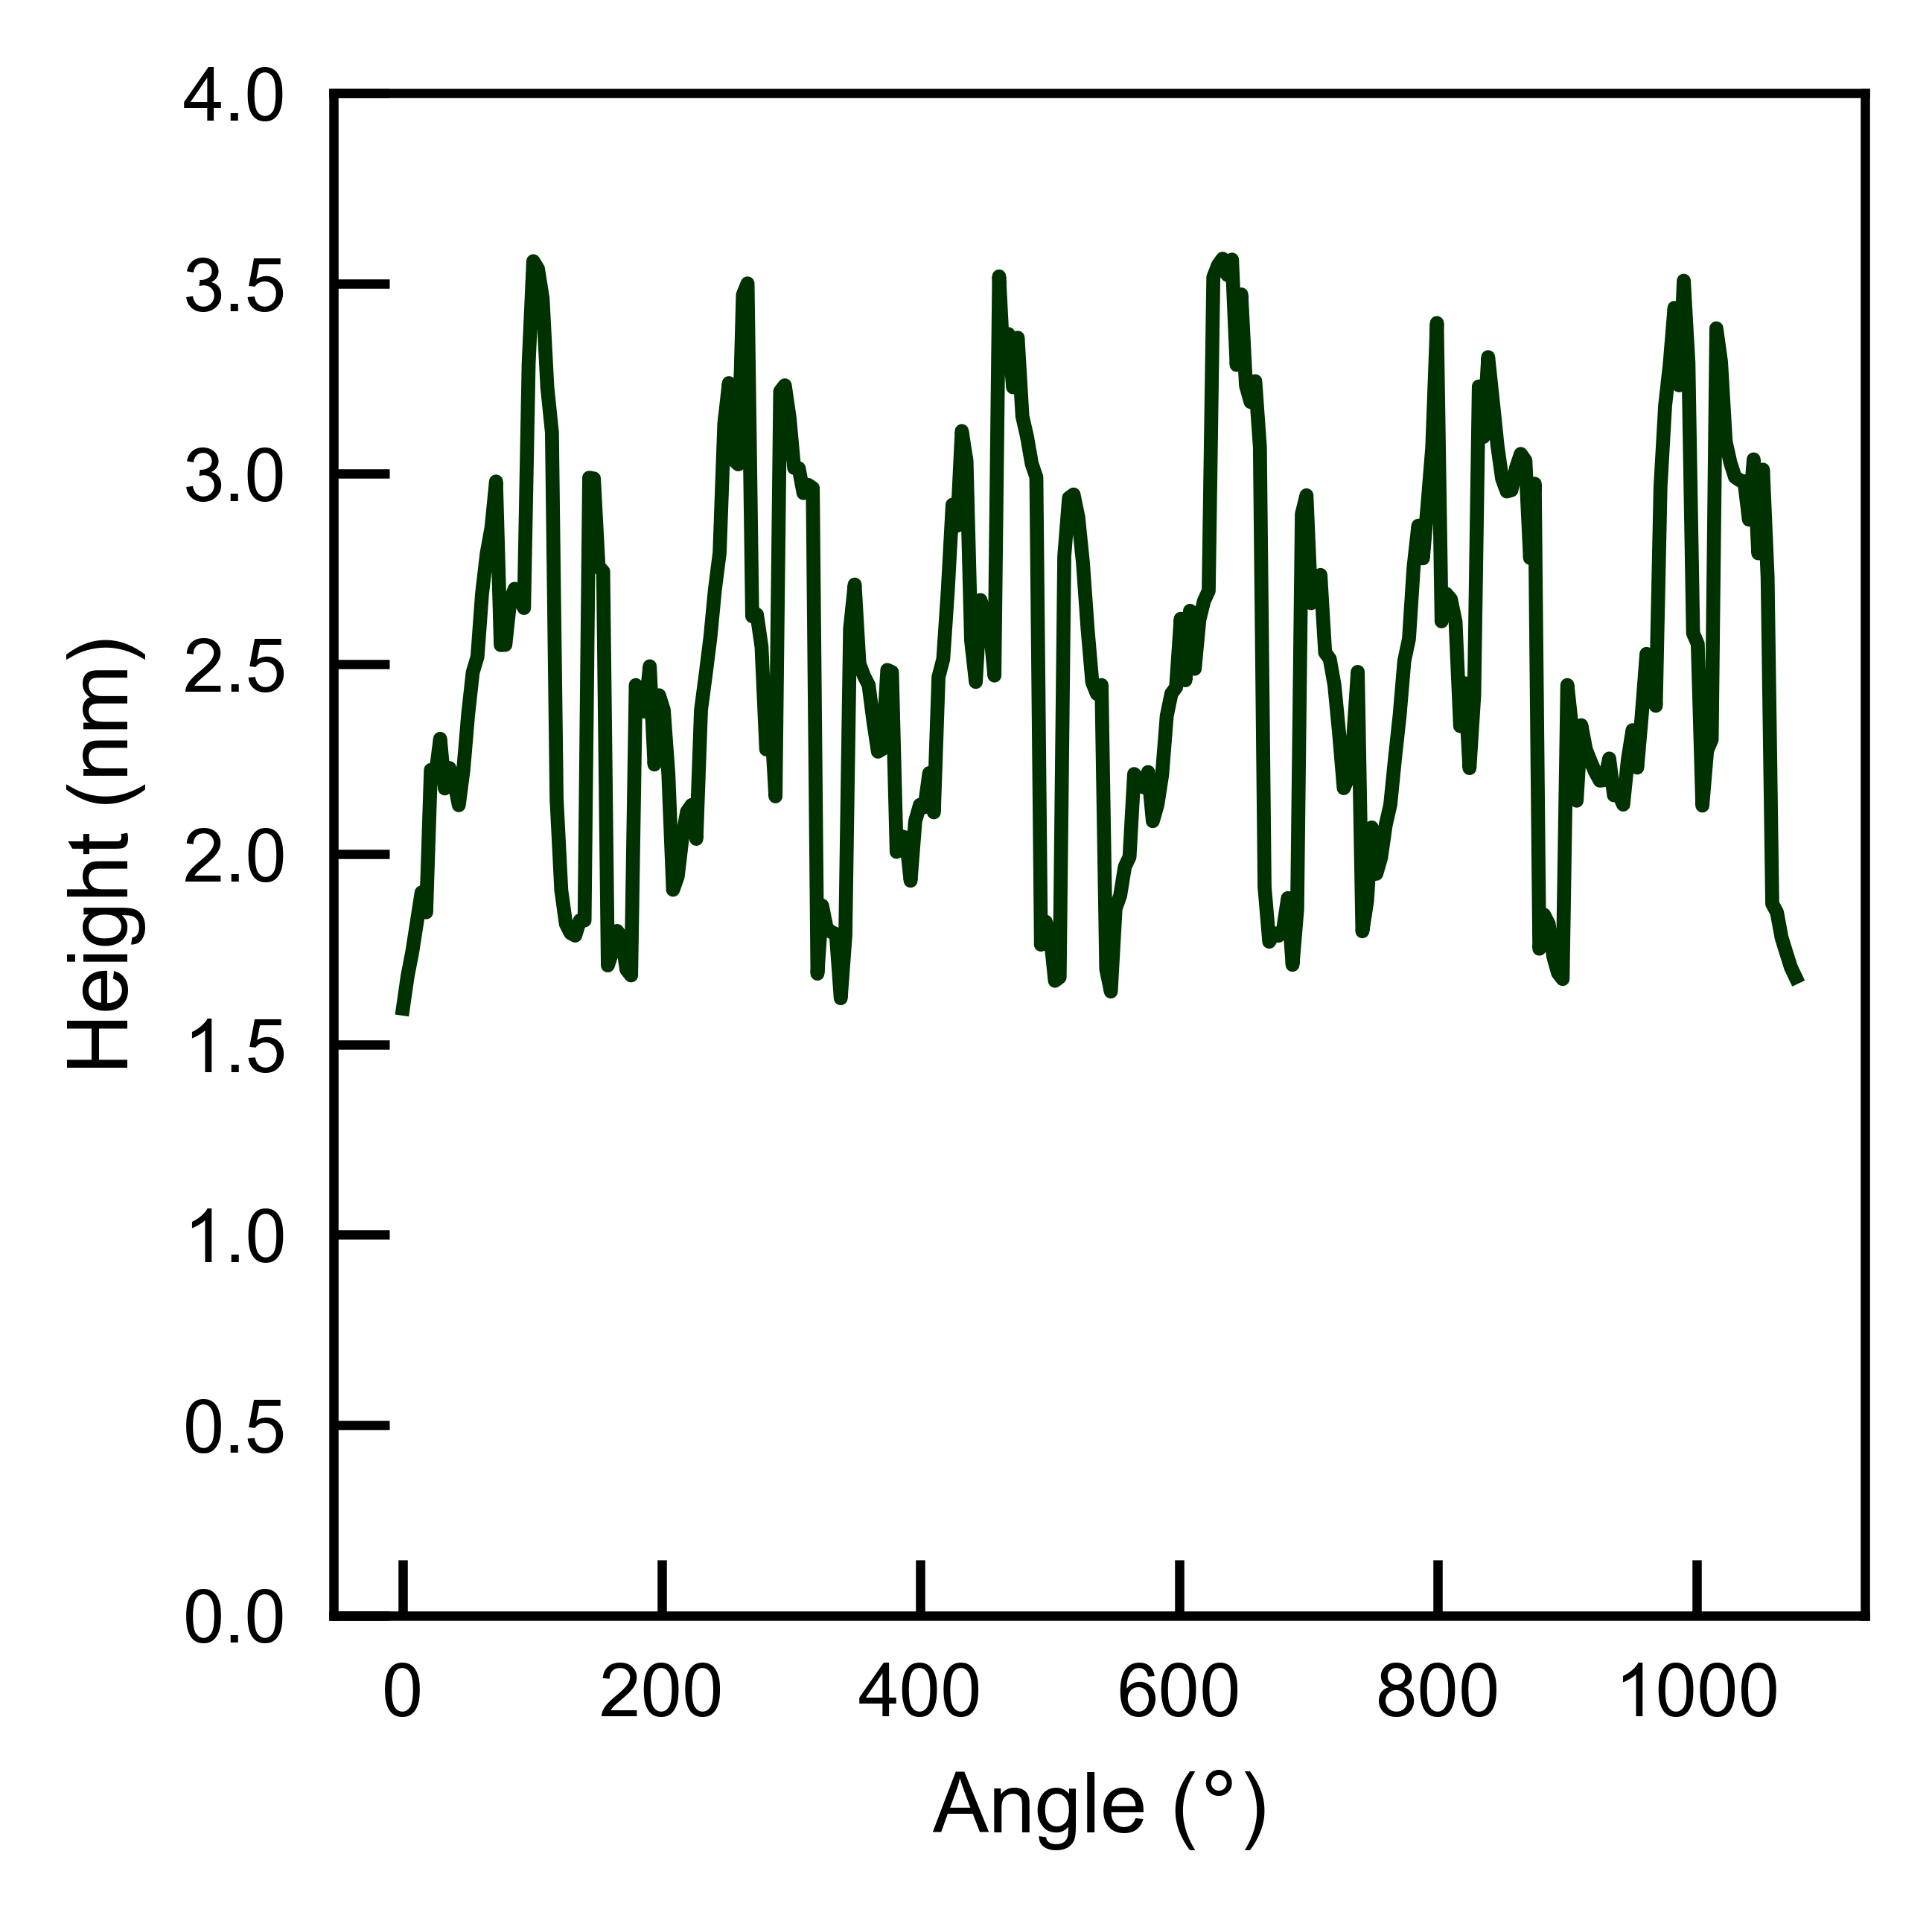

In [94]:
height_array = np.where(sequence, scans, scans_laminated)
fig, ax = plt.subplots(1, 1)
ax.plot(angles, height_array)
ax.set_ylim(0, 4)
ax.set_xlabel('Angle ($\\degree$)')
ax.set_ylabel('Height (nm)')
# plt.savefig(f'./ugree_plot.svg')

plt.show()

## Wavelet transform for defect-rich CNF

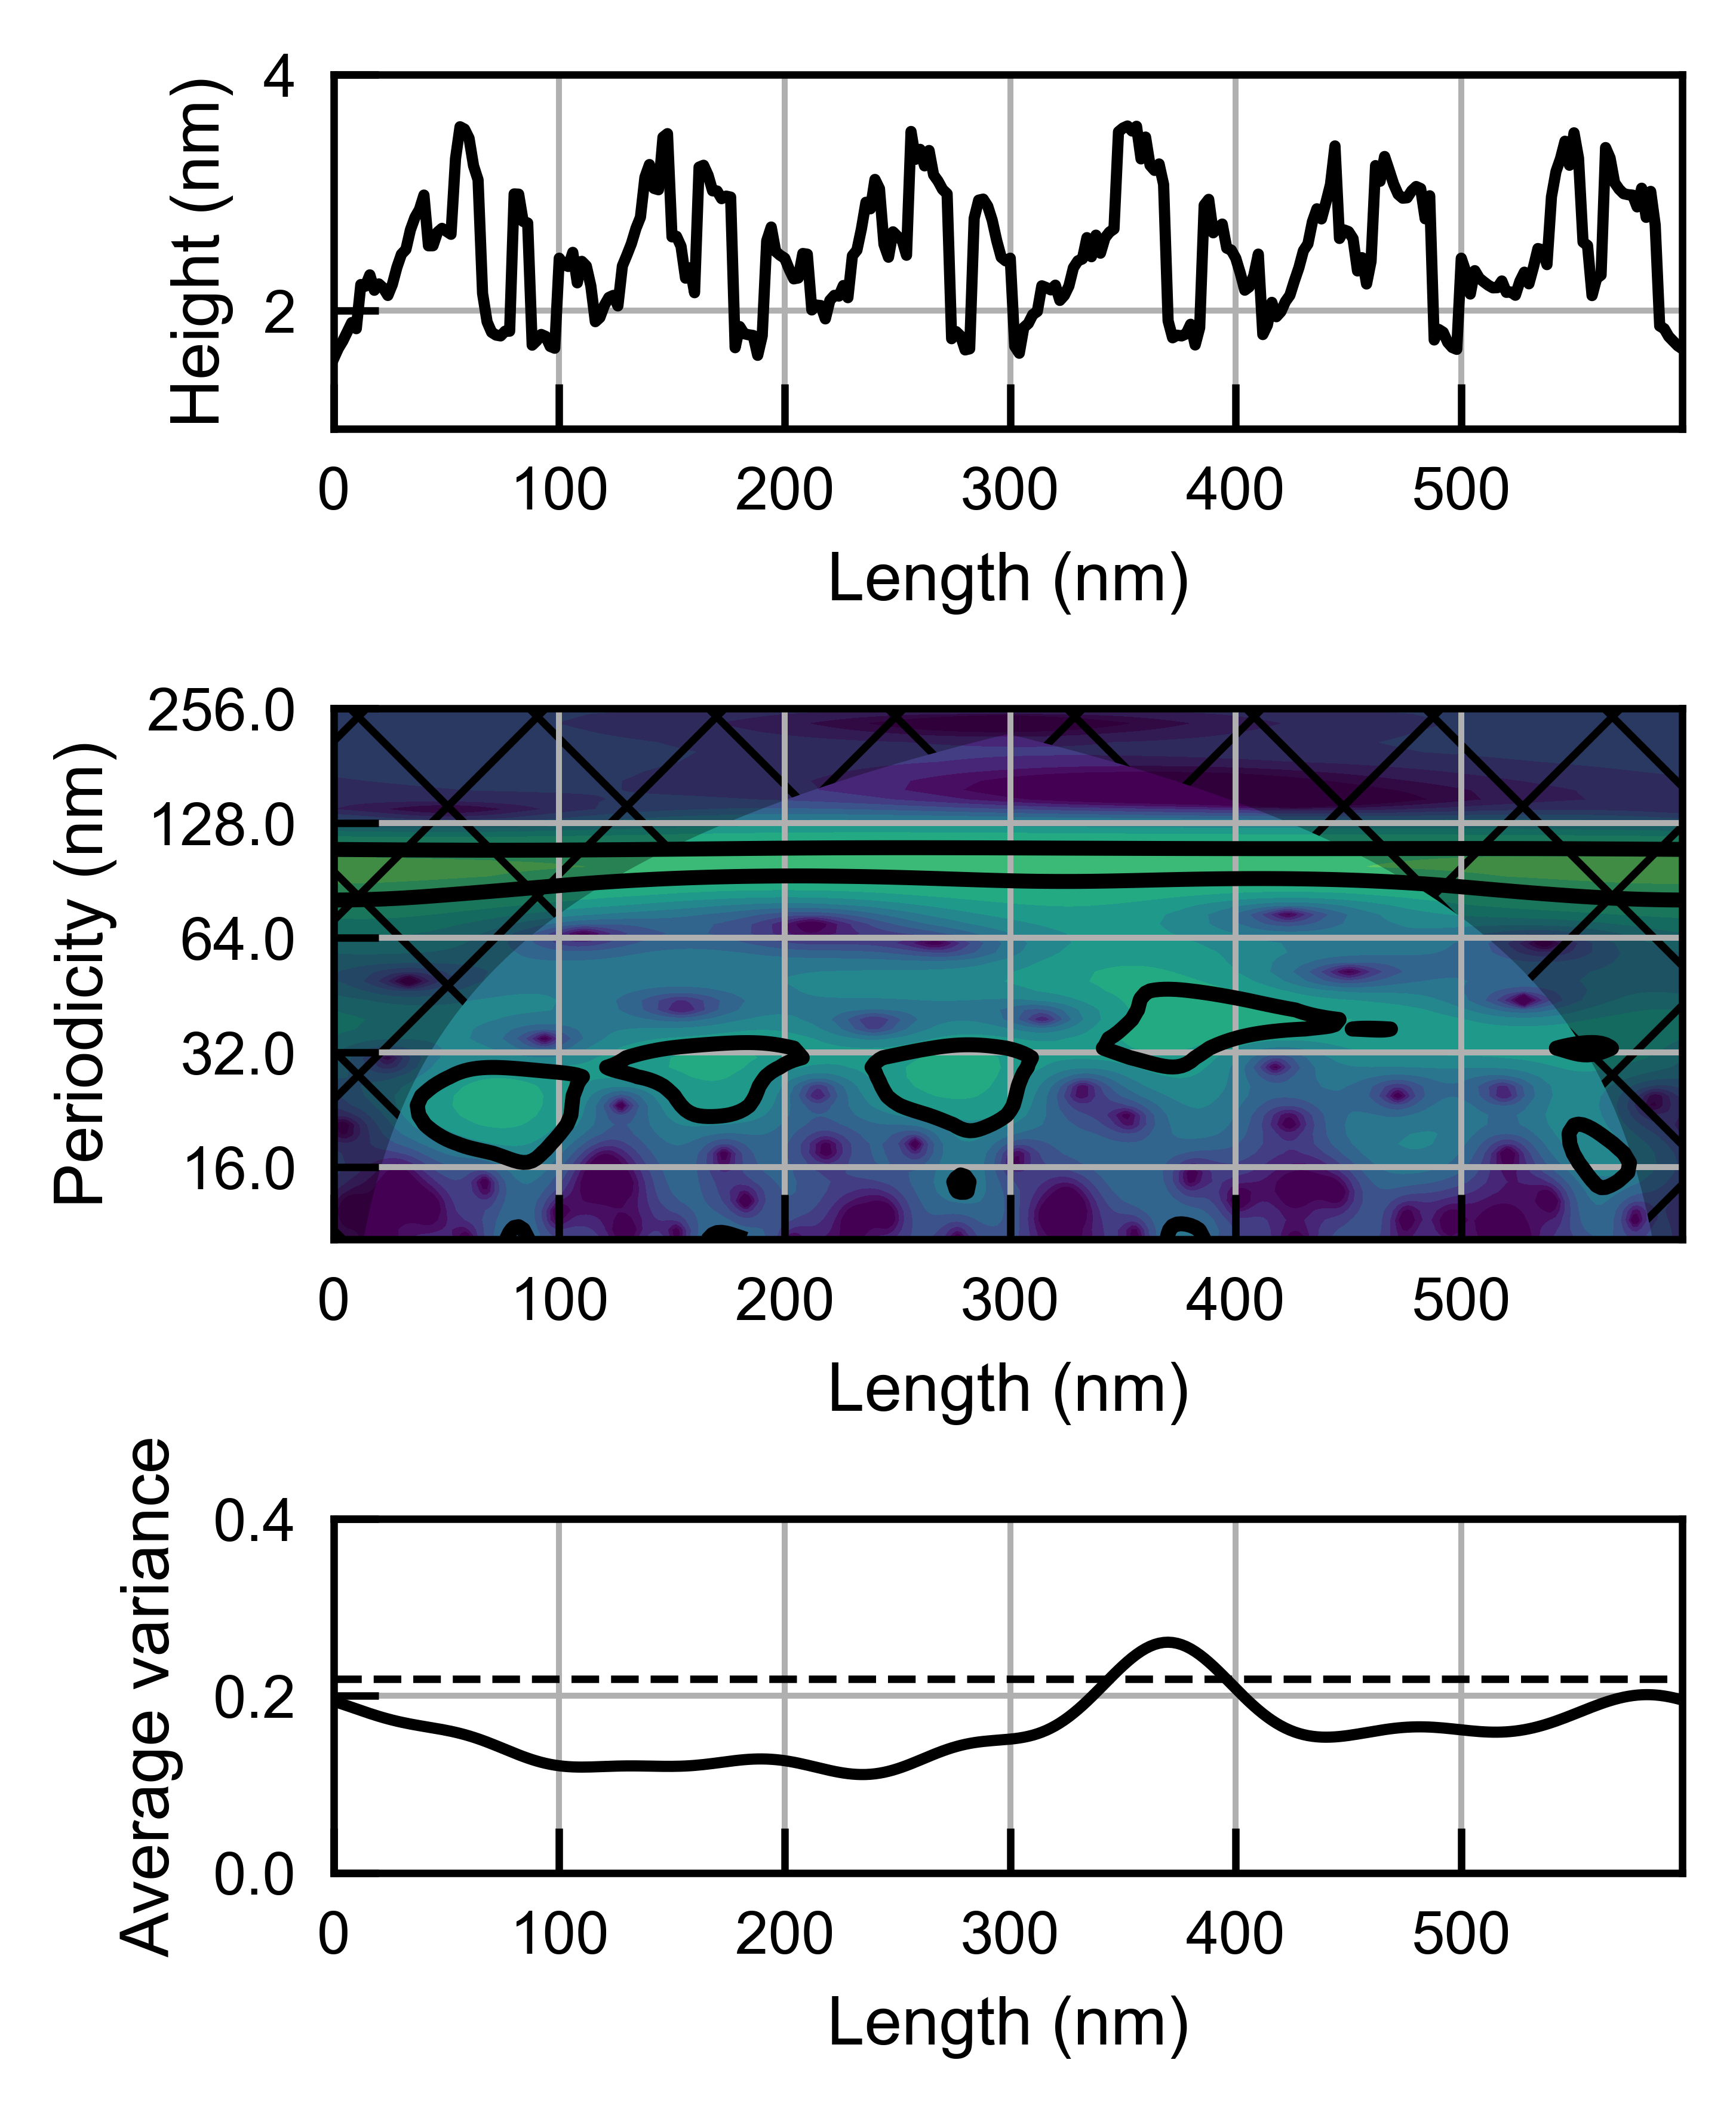

In [96]:
try:
    # dt = 1/1.8 # 1.8 nmごとにデータが取得されているとする(100 nmで180度回転)
    dt = 2
    height = height_array
    horizon = np.arange(0, len(height_array) * dt, dt)

    slevel = 0.95                        # Significance level

    std = height.std()                      # Standard deviation
    std2 = std ** 2                      # Variance
    dat = (height - height.mean()) / std       # Calculating anomaly and normalizing
    dat = np.where((-3 < dat) & (dat < 3), dat, 0) # 極端な値を除去
    
    N = dat.size                            # Number of measurements

    dj = 1 / 12 # 1 /  12                     # Twelve sub-octaves per octaves
    s0 = 5 * dt  # 2 * dt                    # Starting scale, here 6 months
    J = 7 / dj  # 7 / dj                     # Seven powers of two with dj sub-octaves
    #  alpha = 0.0                       # Lag-1 autocorrelation for white noise
    try:
        alpha, _, _ = wavelet.ar1(dat)   # Lag-1 autocorrelation for red noise
    except Warning:
        # When the dataset is too short, or there is a strong trend, ar1 raises a
        # warning. In this case, we assume a white noise background spectrum.
        alpha = 1.0

    mother = wavelet.Morlet(6)           # Morlet mother wavelet with m=6

    # The following routines perform the wavelet transform and siginificance
    # analysis for the chosen data set.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother)

    # Normalized wavelet and Fourier power spectra
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    avg1, avg2 = (32, 128)                  # Range of periods to average

    # Significance test. Where ratio power/sig95 > 1, power is significant.
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=slevel,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    # Power rectification as of Liu et al. (2007). TODO: confirm if significance
    # test ratio should be calculated first.
    # power /= scales[:, None]

    # Calculates the global wavelet spectrum and determines its significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales                     # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                                            significance_level=slevel, dof=dof,
                                            wavelet=mother)

    # Scale average between avg1 and avg2 periods and significance level
    sel = find((period >= avg1) & (period < avg2))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((N, 1))).transpose()
    # As in Torrence and Compo (1998) equation 24
    scale_avg = power / scale_avg
    scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                                                 significance_level=slevel,
                                                 dof=[scales[sel[0]],
                                                      scales[sel[-1]]],
                                                 wavelet=mother)

    fig = plt.figure(figsize=(3.3, 4))
    # gs = GridSpec(3, 2, width_ratios=[3, 1], height_ratios=[2, 3, 2])
    gs = GridSpec(3, 1, height_ratios=[2, 3, 2])

    ax_nino3 = fig.add_subplot(gs[0, 0])
    ax_wave = fig.add_subplot(gs[1, 0], sharex=ax_nino3)
    # ax_gl_spec = fig.add_subplot(gs[1, 1], sharey=ax_wave)
    ax_scl_avg = fig.add_subplot(gs[2, 0], sharex=ax_nino3)
    # for a in [ax_nino3, ax_wave, ax_gl_spec, ax_scl_avg]:
    for a in [ax_nino3, ax_wave, ax_scl_avg]:
        a.grid(True)

    ax_nino3.plot(horizon, height, 'k', linewidth=1.5)
    ax_nino3.set_ylim(1,4)
    ax_nino3.set_ylabel('Height (nm)')
    ax_nino3.set_xlabel('Length (nm)')

    # Contour plot wavelet power spectrum
    levels = np.exp2(np.arange(-5, 10))
    ax_wave.contourf(horizon, np.log2(period), np.log2(power), np.log2(levels),
                     extend='both', cmap=plt.cm.viridis)
    extent = horizon.min(), horizon.max(), 0, max(period)

    ax_wave.contour(horizon, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                    extent=extent) # 95% significance contour

    ax_wave.fill(np.concatenate([horizon, horizon[-1:] + dt, horizon[-1:] + dt,
                                 horizon[:1] - dt, horizon[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
    ax_wave.set_ylabel('Periodicity (nm)')
    ax_wave.set_xlabel('Length (nm)')
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                            np.ceil(np.log2(period.max())))
    ax_wave.set_yticks(np.log2(Yticks))
    ax_wave.set_yticklabels(Yticks)
    ax_wave.set_ylim(np.log2([period.min(), 256]))

    # Scale-averaged power spectrum
    ax_scl_avg.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
    ax_scl_avg.plot(horizon, scale_avg, 'k-', linewidth=1.5)
    ax_scl_avg.set_xlabel('Length (nm)')
    ax_scl_avg.set_ylabel('Average variance')

    ax_scl_avg.set_xlim([horizon.min(), horizon.max()])
    ax_scl_avg.set_yticks(np.arange(0, 0.6, 0.2))

    plt.tight_layout()

    plt.show()
except RuntimeWarning:
    print('Divided by zero')